# Toy Model Experiments: JumpReLU edition

We focus on BatchTopK SAEs in the paper since its easier to directly control their L0, but we show here that the same findings still hold for JumpReLU SAEs as well. We just run the nth decoder projection experiment here, showing that JumpReLU SAEs also minimize this metric at the correct L0.

/Users/davidchanin/dev/sparse-but-wrong-paper/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
loss: 0.058: 100%|██████████| 1000/1000 [00:00<00:00, 1108.08it/s]
/var/folders/0l/9g9hj_kx0_3_mfrghdq5df980000gn/T/ipykernel_23258/3033965947.py:50: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


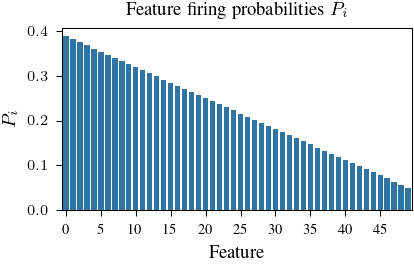

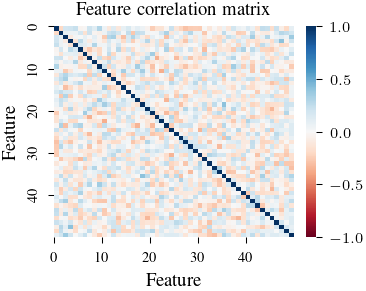

In [1]:
from functools import partial
from pathlib import Path
import torch
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from sparse_but_wrong.toy_models.get_training_batch import generate_random_correlation_matrix, get_training_batch
from sparse_but_wrong.toy_models.toy_model import ToyModel
from sparse_but_wrong.toy_models.plotting import SEABORN_RC_CONTEXT
from sparse_but_wrong.util import DEFAULT_DEVICE

tqdm._instances.clear()  # type: ignore

feat_probs = 0.345 * (50 - torch.arange(50) - 1) / 50 + 0.05
correlations = generate_random_correlation_matrix(
    correlation_strength_range=(0.3, 0.9),
    num_features=50,
    seed=42,
)
indices = torch.arange(50) + 1
df = pd.DataFrame({
    "P_i": feat_probs,
    "feature": map(str, indices.tolist()),
})


toy_model = ToyModel(num_feats=50, hidden_dim=100).to(DEFAULT_DEVICE)


generate_batch = partial(
    get_training_batch,
    firing_probabilities=feat_probs,
    std_firing_magnitudes=torch.ones_like(feat_probs) * 0.15,
    correlation_matrix=correlations,
)

Path("plots/toy_setup_jumprelu").mkdir(parents=True, exist_ok=True)

plt.rcParams.update({"figure.dpi": 150})
with plt.rc_context(SEABORN_RC_CONTEXT):
    plt.figure(figsize=(3, 2))
    sns.barplot(data=df, x="feature", y="P_i")
    plt.xlabel("Feature")
    plt.ylabel("$P_i$")
    plt.title("Feature firing probabilities $P_i$")
    # Increase tick spacing to prevent overlapping
    plt.xticks(range(0, len(df), 5), [str(i) for i in range(0, len(df), 5)])  # Show every 5th tick, 0-indexed
    plt.tight_layout()
    plt.savefig("plots/toy_setup_jumprelu/toy_model_feature_firing_probabilities.pdf")
    plt.show()

plt.rcParams.update({"figure.dpi": 150})
with plt.rc_context(SEABORN_RC_CONTEXT):
    plt.figure(figsize=(2.5, 2))
    sns.heatmap(correlations, cmap="RdBu", center=0, vmin=-1, vmax=1)
    plt.xlabel("Feature")
    plt.ylabel("Feature")
    plt.title("Feature correlation matrix")
    # Increase tick spacing to prevent overlapping
    plt.xticks(range(0, len(correlations), 10), [str(i) for i in range(0, len(correlations), 10)])  # Show every 10th tick, 0-indexed
    plt.yticks(range(0, len(correlations), 10), [str(i) for i in range(0, len(correlations), 10)])  # Show every 10th tick, 0-indexed
    # plt.tight_layout()
    plt.savefig("plots/toy_setup_jumprelu/toy_model_correlation_matrix.pdf")
    plt.show()

## Finding the True L0

Next, we calculate the true L0 for this dataset (spoiler: it's ~11)

In [2]:
sample = generate_batch(100_000)
true_l0 = (sample > 0).float().sum(dim=-1).mean()
print(f"True L0: {true_l0}")

True L0: 10.964269638061523


In [ ]:
from sae_lens import JumpReLUTrainingSAE, JumpReLUTrainingSAEConfig
from sparse_but_wrong.toy_models.eval_sae import eval_sae
from sparse_but_wrong.toy_models.train_toy_sae import train_toy_sae

cfg = JumpReLUTrainingSAEConfig(
        l0_coefficient=1.0,
        jumprelu_bandwidth=1.0,
        jumprelu_init_threshold=0.1,
        jumprelu_sparsity_loss_mode="tanh",
        l0_warm_up_steps=10_000,
        normalize_activations="expected_average_only_in",
        d_in=toy_model.embed.weight.shape[0],
        d_sae=50,
    )
sae_full = JumpReLUTrainingSAE(cfg)

# NOTE: occasionaly this gets stuck in poor local minima. If this happens, try rerunning and it should converge properly.
train_toy_sae(sae_full, toy_model, generate_batch)
stats = eval_sae(sae_full, toy_model, generate_batch)
print(f"SAE L0: {stats.sae_l0}, dead latents: {stats.dead_features}, L1 coefficient: {1.0:.2f}")

/Users/davidchanin/dev/sparse-but-wrong-paper/.venv/lib/python3.11/site-packages/sae_lens/saes/sae.py:249: UserWarning:


This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)

Estimating norm scaling factor: 100%|██████████| 1000/1000 [00:07<00:00, 141.05it/s]
14600| mse_loss: 1.09525 | l0_loss: 11.31934: 100%|█████████▉| 14950400/15000000 [02:31<00:00, 98927.34it/s] 


SAE L0: 11.13107967376709, dead latents: 0, L1 coefficient: 1.00


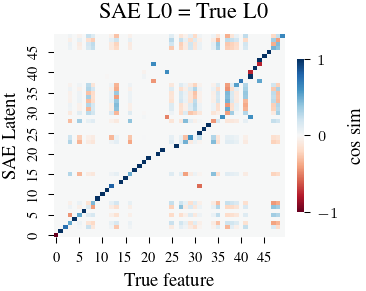

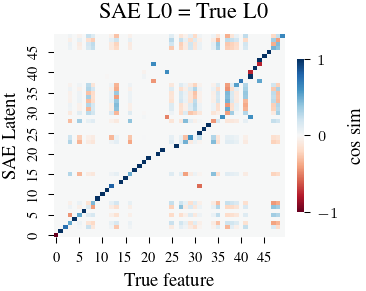

In [ ]:
from sparse_but_wrong.toy_models.plotting import plot_sae_feat_cos_sims, plot_sae_feat_cos_sims_seaborn

plot_sae_feat_cos_sims(sae_full, toy_model, "SAE L0 = True L0", reorder_features=True, dtick=5)
plot_sae_feat_cos_sims_seaborn(sae_full, toy_model, title="SAE L0 = True L0", reorder_features=True, decoder_only=True, width=5, height=2, dtick=5, decoder_title=None, save_path="plots/toy_l0_jumprelu/sae_l0_eq_true_l0_decoder_cos_sims.pdf")
plot_sae_feat_cos_sims_seaborn(sae_full, toy_model, title="SAE L0 = True L0", reorder_features=True, decoder_only=True, width=5, height=2, dtick=5, decoder_title=None, save_path="plots/toy_l0_jumprelu/sae_l0_eq_true_l0_decoder_cos_sims.png")

# Can we detect when we're at the correct L0?

Let's train SAEs at a range of L0, ranging from below the correct L0 to above the correct L0

In [32]:
from sae_lens import JumpReLUTrainingSAE, JumpReLUTrainingSAEConfig
from sparse_but_wrong.toy_models.train_toy_sae import train_toy_sae
from sparse_but_wrong.toy_models.eval_sae import eval_sae



saes_by_k = {}
for l1 in [0.05, 0.07, 0.09, 0.1, 0.3, 0.5, 0.75, 1.0, 1.2, 1.3, 1.4, 1.5]:
    print(f"Training SAE with l1={l1}")
    cfg = JumpReLUTrainingSAEConfig(
        l0_coefficient=l1,
        jumprelu_bandwidth=2.0,
        jumprelu_init_threshold=0.1,
        jumprelu_sparsity_loss_mode="tanh",
        l0_warm_up_steps=10_000,
        normalize_activations="expected_average_only_in",
        d_in=toy_model.embed.weight.shape[0],
        d_sae=50,
    )
    sae = JumpReLUTrainingSAE(cfg)
    train_toy_sae(sae, toy_model, generate_batch)
    stats = eval_sae(sae, toy_model, generate_batch)
    print(f"SAE L0: {stats.sae_l0}, dead latents: {stats.dead_features}, L1 coefficient: {l1:.2f}")
    saes_by_k[stats.sae_l0] = sae


/Users/davidchanin/dev/sparse-but-wrong-paper/.venv/lib/python3.11/site-packages/sae_lens/saes/sae.py:249: UserWarning:


This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)



Training SAE with l1=0.05


Estimating norm scaling factor: 100%|██████████| 1000/1000 [00:06<00:00, 159.01it/s]


Estimated scaling factor: 3.0252307438111297


14600| mse_loss: 0.33383 | l0_loss: 1.39697: 100%|█████████▉| 14950400/15000000 [02:24<00:00, 103595.13it/s]


SAE L0: 27.664649963378906, dead latents: 0, L1 coefficient: 0.05
Training SAE with l1=0.07


Estimating norm scaling factor: 100%|██████████| 1000/1000 [00:06<00:00, 161.38it/s]


Estimated scaling factor: 3.025445565257802


14600| mse_loss: 0.09643 | l0_loss: 1.55099: 100%|█████████▉| 14950400/15000000 [02:23<00:00, 104062.37it/s]


SAE L0: 22.270620346069336, dead latents: 0, L1 coefficient: 0.07
Training SAE with l1=0.09


Estimating norm scaling factor: 100%|██████████| 1000/1000 [00:06<00:00, 160.67it/s]


Estimated scaling factor: 3.025535245627466


14600| mse_loss: 0.00637 | l0_loss: 1.63055: 100%|█████████▉| 14950400/15000000 [02:22<00:00, 104883.45it/s]


SAE L0: 18.150489807128906, dead latents: 0, L1 coefficient: 0.09
Training SAE with l1=0.1


Estimating norm scaling factor: 100%|██████████| 1000/1000 [00:06<00:00, 158.09it/s]


Estimated scaling factor: 3.0262599862021724


14600| mse_loss: 0.01872 | l0_loss: 1.78066: 100%|█████████▉| 14950400/15000000 [02:25<00:00, 102881.68it/s]


SAE L0: 17.630769729614258, dead latents: 0, L1 coefficient: 0.10
Training SAE with l1=0.3


Estimating norm scaling factor: 100%|██████████| 1000/1000 [00:06<00:00, 164.00it/s]


Estimated scaling factor: 3.0244505875701444


14600| mse_loss: 0.09143 | l0_loss: 3.94219: 100%|█████████▉| 14950400/15000000 [02:26<00:00, 102207.93it/s]


SAE L0: 12.94927978515625, dead latents: 0, L1 coefficient: 0.30
Training SAE with l1=0.5


Estimating norm scaling factor: 100%|██████████| 1000/1000 [00:06<00:00, 164.26it/s]


Estimated scaling factor: 3.024741278401487


14600| mse_loss: 0.00011 | l0_loss: 5.87158: 100%|█████████▉| 14950400/15000000 [02:20<00:00, 106304.75it/s]


SAE L0: 11.606619834899902, dead latents: 0, L1 coefficient: 0.50
Training SAE with l1=0.75


Estimating norm scaling factor: 100%|██████████| 1000/1000 [00:05<00:00, 168.40it/s]


Estimated scaling factor: 3.0253383138379637


14600| mse_loss: 1.28604 | l0_loss: 8.25146: 100%|█████████▉| 14950400/15000000 [02:20<00:00, 106100.67it/s]


SAE L0: 10.988900184631348, dead latents: 2, L1 coefficient: 0.75
Training SAE with l1=1.0


Estimating norm scaling factor: 100%|██████████| 1000/1000 [00:06<00:00, 165.74it/s]


Estimated scaling factor: 3.0256589242961947


14600| mse_loss: 2.81772 | l0_loss: 10.22656: 100%|█████████▉| 14950400/15000000 [02:20<00:00, 106244.70it/s]


SAE L0: 10.21675968170166, dead latents: 0, L1 coefficient: 1.00
Training SAE with l1=1.2


Estimating norm scaling factor: 100%|██████████| 1000/1000 [00:06<00:00, 162.71it/s]


Estimated scaling factor: 3.025560502472303


14600| mse_loss: 9.76756 | l0_loss: 10.47305: 100%|█████████▉| 14950400/15000000 [02:16<00:00, 109273.52it/s]


SAE L0: 8.4102201461792, dead latents: 1, L1 coefficient: 1.20
Training SAE with l1=1.3


Estimating norm scaling factor: 100%|██████████| 1000/1000 [00:06<00:00, 164.26it/s]


Estimated scaling factor: 3.0253692893614863


14600| mse_loss: 41.39203 | l0_loss: 3.80352: 100%|█████████▉| 14950400/15000000 [02:21<00:00, 105988.23it/s] 


SAE L0: 2.7920000553131104, dead latents: 1, L1 coefficient: 1.30
Training SAE with l1=1.4


Estimating norm scaling factor: 100%|██████████| 1000/1000 [00:05<00:00, 167.69it/s]


Estimated scaling factor: 3.025057286433117


14600| mse_loss: 2.66962 | l0_loss: 15.05410: 100%|█████████▉| 14950400/15000000 [02:16<00:00, 109397.48it/s]


SAE L0: 10.739970207214355, dead latents: 0, L1 coefficient: 1.40
Training SAE with l1=1.5


Estimating norm scaling factor: 100%|██████████| 1000/1000 [00:06<00:00, 165.44it/s]


Estimated scaling factor: 3.0253434840551496


14600| mse_loss: 49.62997 | l0_loss: 2.88721: 100%|█████████▉| 14950400/15000000 [02:21<00:00, 105914.99it/s] 


SAE L0: 1.8168699741363525, dead latents: 1, L1 coefficient: 1.50


100%|██████████| 12/12 [00:09<00:00,  1.33it/s]
/var/folders/0l/9g9hj_kx0_3_mfrghdq5df980000gn/T/ipykernel_91673/2331987097.py:51: UserWarning:

The figure layout has changed to tight



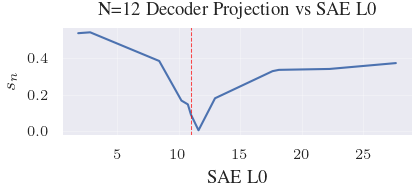

/var/folders/0l/9g9hj_kx0_3_mfrghdq5df980000gn/T/ipykernel_91673/2331987097.py:51: UserWarning:

The figure layout has changed to tight



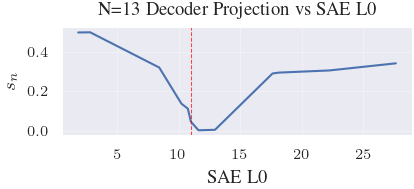

/var/folders/0l/9g9hj_kx0_3_mfrghdq5df980000gn/T/ipykernel_91673/2331987097.py:51: UserWarning:

The figure layout has changed to tight



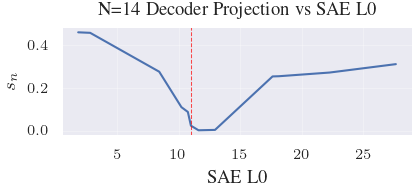

/var/folders/0l/9g9hj_kx0_3_mfrghdq5df980000gn/T/ipykernel_91673/2331987097.py:51: UserWarning:

The figure layout has changed to tight



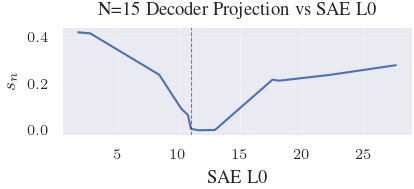

/var/folders/0l/9g9hj_kx0_3_mfrghdq5df980000gn/T/ipykernel_91673/2331987097.py:51: UserWarning:

The figure layout has changed to tight



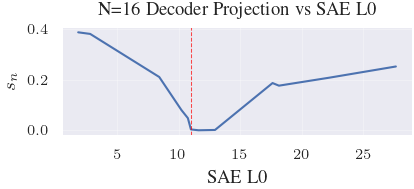

/var/folders/0l/9g9hj_kx0_3_mfrghdq5df980000gn/T/ipykernel_91673/2331987097.py:51: UserWarning:

The figure layout has changed to tight



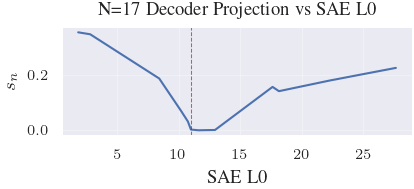

/var/folders/0l/9g9hj_kx0_3_mfrghdq5df980000gn/T/ipykernel_91673/2331987097.py:51: UserWarning:

The figure layout has changed to tight



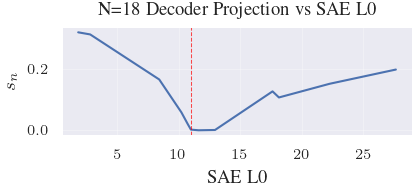

/var/folders/0l/9g9hj_kx0_3_mfrghdq5df980000gn/T/ipykernel_91673/2331987097.py:51: UserWarning:

The figure layout has changed to tight



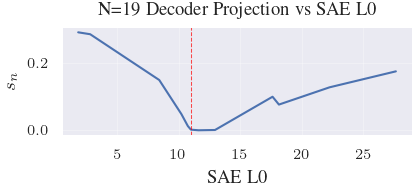

/var/folders/0l/9g9hj_kx0_3_mfrghdq5df980000gn/T/ipykernel_91673/2331987097.py:51: UserWarning:

The figure layout has changed to tight



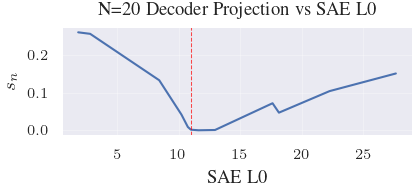

/var/folders/0l/9g9hj_kx0_3_mfrghdq5df980000gn/T/ipykernel_91673/2331987097.py:51: UserWarning:

The figure layout has changed to tight



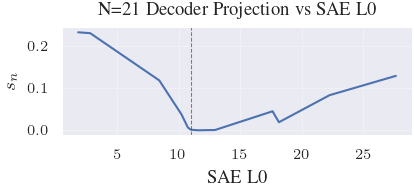

/var/folders/0l/9g9hj_kx0_3_mfrghdq5df980000gn/T/ipykernel_91673/2331987097.py:51: UserWarning:

The figure layout has changed to tight



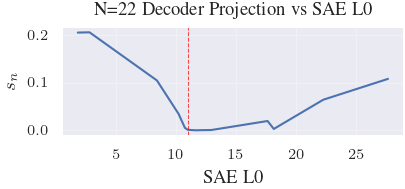

/var/folders/0l/9g9hj_kx0_3_mfrghdq5df980000gn/T/ipykernel_91673/2331987097.py:51: UserWarning:

The figure layout has changed to tight



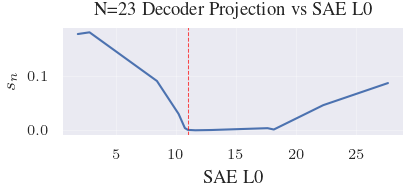

/var/folders/0l/9g9hj_kx0_3_mfrghdq5df980000gn/T/ipykernel_91673/2331987097.py:51: UserWarning:

The figure layout has changed to tight



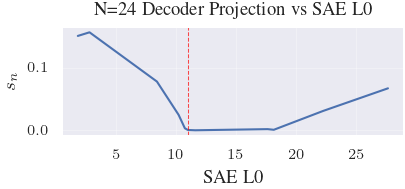

/var/folders/0l/9g9hj_kx0_3_mfrghdq5df980000gn/T/ipykernel_91673/2331987097.py:51: UserWarning:

The figure layout has changed to tight



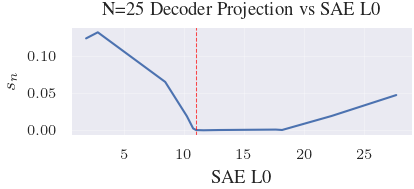

In [ ]:
from pathlib import Path
from typing import Callable
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sae_lens import TrainingSAE
from sparse_but_wrong.toy_models.plotting import SEABORN_RC_CONTEXT

# Assuming ToyModel and other variables are defined elsewhere
# from your_module import ToyModel, saes_by_k, toy_model, generate_batch

sorted_dec_hidden_pres = {}

def calc_l0_dec_thresholds(sae: TrainingSAE, model, generate_batch: Callable[[int], torch.Tensor]) -> list[float]:
    inputs = model.embed(generate_batch(100_000))
    hidden_pre_dec = (inputs - sae.b_dec) @ sae.W_dec.T
    sorted_hidden_pre_dec = hidden_pre_dec.flatten().sort(descending=True).values
    k_inds = torch.arange(hidden_pre_dec.shape[-1]) * hidden_pre_dec.shape[0]
    return sorted_hidden_pre_dec[k_inds].tolist()

thresholds = {}
for k, sae in tqdm(saes_by_k.items()):
    thresholds[k] = calc_l0_dec_thresholds(sae, toy_model, generate_batch)

data = []
for l0, l0_thresholds in thresholds.items():
    row = {"l0": l0}
    for i, threshold in enumerate(l0_thresholds):
        row[f"l0_dec_{i}"] = threshold
    data.append(row)
df = pd.DataFrame(data)

Path("plots/dpn_jumprelu").mkdir(parents=True, exist_ok=True)
for k in [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]:
    plt.rcParams.update({"figure.dpi": 150})
    sns.set_theme()
    with plt.rc_context(SEABORN_RC_CONTEXT):
        plt.figure(figsize=(3, 1.5))
        sns.lineplot(data=df, x="l0", y=f"l0_dec_{k}")
        
        # Add vertical line at true L0
        plt.axvline(x=11, color='red', linestyle='--', linewidth=0.5, alpha=0.7, label='True L0')
        
        plt.title(f"N={k} Decoder Projection vs SAE L0")
        plt.xlabel("SAE L0")
        plt.ylabel("$s_n$")
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f"plots/dpn_jumprelu/dp_{k}.pdf")
        plt.show()

100%|██████████| 12/12 [00:00<00:00, 79512.87it/s]
/var/folders/0l/9g9hj_kx0_3_mfrghdq5df980000gn/T/ipykernel_91673/1983969609.py:20: UserWarning:

The figure layout has changed to tight



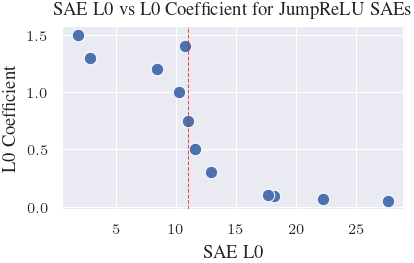

In [44]:
from sparse_but_wrong.toy_models.plotting import SEABORN_RC_CONTEXT
import matplotlib.pyplot as plt
import seaborn as sns

data = []
for k, sae in tqdm(saes_by_k.items()):
    data.append({"l0": k, "l0_coeff": sae.cfg.l0_coefficient})
df = pd.DataFrame(data)

plt.rcParams.update({"figure.dpi": 150})
with plt.rc_context(SEABORN_RC_CONTEXT):
    plt.figure(figsize=(3, 2))
    sns.scatterplot(data=df, x="l0", y="l0_coeff")

    # Add vertical line at true L0
    plt.axvline(x=11, color='red', linestyle='--', linewidth=0.5, alpha=0.7, label='True L0')
    plt.xlabel("SAE L0")
    plt.ylabel("L0 Coefficient")
    plt.title("SAE L0 vs L0 Coefficient for JumpReLU SAEs")
    plt.tight_layout()
    plt.savefig("plots/toy_l0_jumprelu/l0_vs_l0_coeff_jumprelu.pdf")
    plt.show()